In [1]:
import sys
sys.path.append('../')
import potentials

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
import pickle
import pandas as pd
from itertools import product as prod
import proplot as pplt
nr, nc = 128, 256

np.random.seed(110104)
plt.rc("text", usetex=True)

In [3]:
# # W = signal.correlate2d(Z2, U, mode='same')
# # plt.imshow(W)

# def local_potential(ksize: int):
#     K = np.zeros((ksize, ksize))
#     for i in range(ksize):
#         for j in range(ksize):
#             x = [i - ksize//2, j - ksize//2]
#             K[i, j] = np.linalg.norm(x, 2) / ksize
#     return K
    
# def center_crop(x: np.ndarray, pad: int):
#     assert pad > 1
#     return x[(pad):-(pad), (pad):-(pad)]


# def local_potential(ksize: int):
#     K = np.zeros((ksize, ksize))
#     for i in range(ksize):
#         for j in range(ksize):
#             x = [i - ksize // 2, j - ksize // 2]
#             K[i, j] = np.linalg.norm(x, 2) / ksize
#     return K


# def diff(X, axis):
#     padw = [[0, 0] for _ in range(len(X.shape))]
#     padw[axis] = [1, 0]
#     X_ = np.pad(X, padw, mode='linear_ramp')
#     return np.diff(X_, 1, axis)

# def sample_gp2d(
#     nr: int, nc: int, a: float = 1.0, b: float = 1.0,
# ) -> np.ndarray:
#     K = np.zeros((nr, nc, nr, nc))
#     rows = np.arange(nr)
#     cols = np.arange(nc)
#     X = np.array(list(prod(rows, cols, rows, cols)))
#     D = X[:, 0:2] - X[:, 2:4]
#     K = a * np.exp(-0.5 * (b ** 2) * np.square(D).sum(-1))
#     K = K.reshape(nr * nc, nr * nc)
#     x = np.random.multivariate_normal(np.zeros(nr * nc), K)
#     x = x.reshape(nr, nc)
#     return x


# def up(x: np.ndarray, factor: int):
#     for _ in range(factor):
#         x = cv2.pyrUp(x)
#     return x

# def diff_change_pot(k: int, axis=0):
#     assert k % 2 == 1
#     out = np.zeros((k, k))
#     if axis == 0:
#         out[:(k//2), :] = -1
#         out[(k//2 + 1):, :] = 1
#     else:
#         out[:, :(k//2)] = -1
#         out[:, (k//2 + 1):] = 1
#     return out

## Analysis with sampled GP

In [4]:
# Z = potentials.sample_gp2d(nr // 4 + 1, nc // 4 + 1, b=0.25)
# Z2 = potentials.up(Z, factor=2)
ksize = 13
nr, nc = 128, 256
U, V, P, L = potentials.potential_features(nr, nc, ksize)

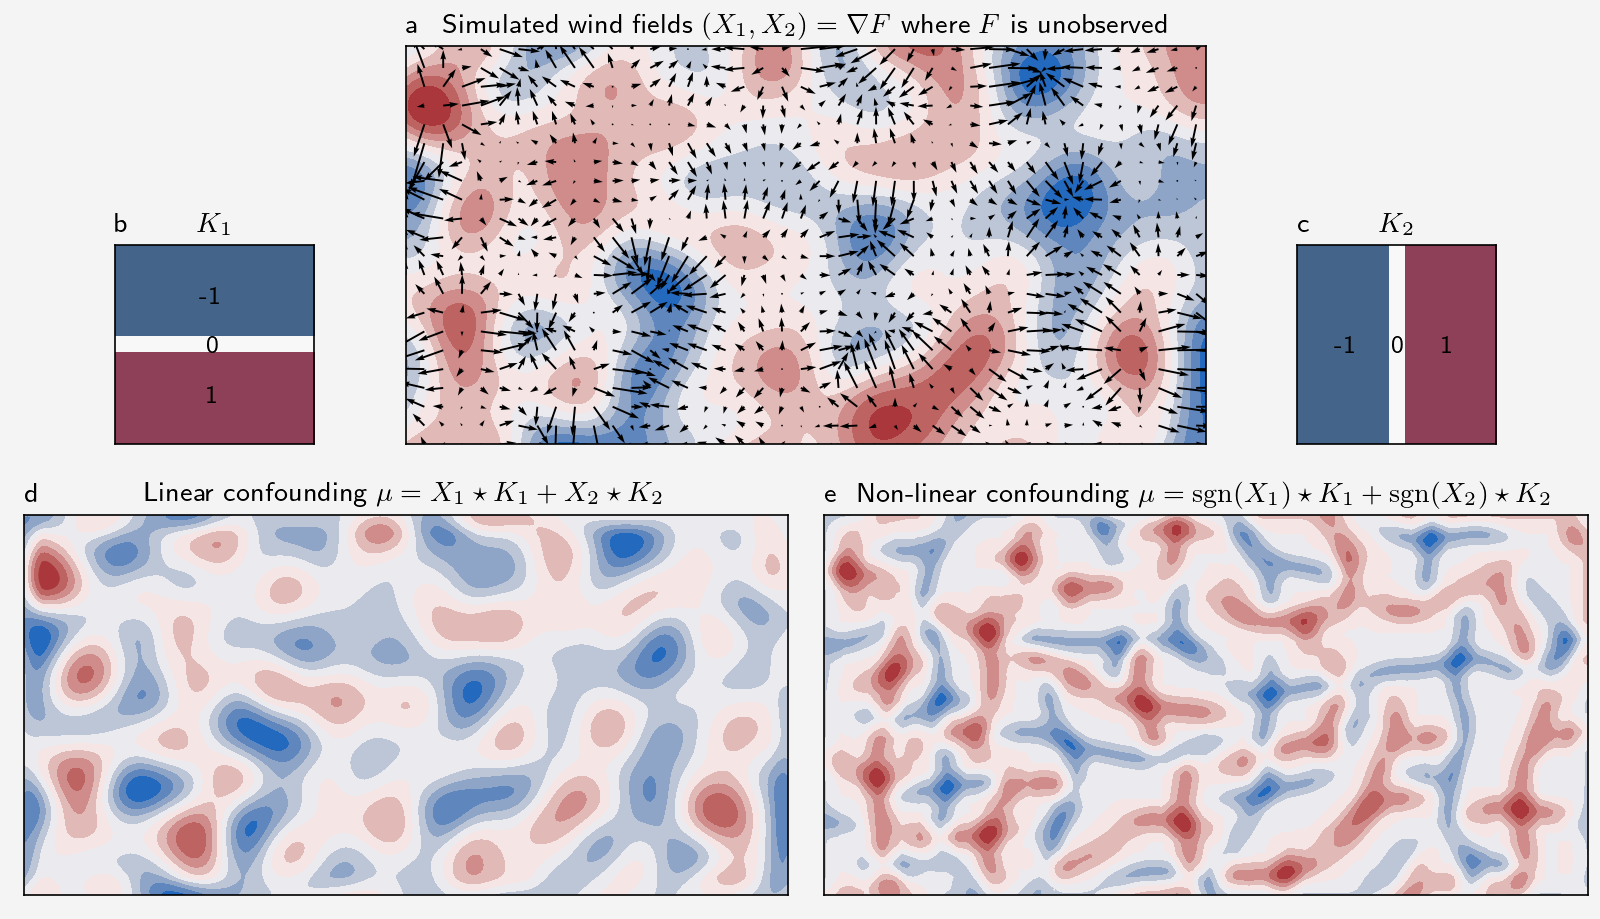

In [8]:
array = [  # the "picture" (0 == nothing, 1 == subplot A, 2 == subplot B, etc.)
    [0, 1, 1, 0],
    [2, 1, 1, 3],
    [4, 4, 5, 5],
    [4, 4, 5, 5],
]

def normalize01(x):
    return (x - x.min()) / (x.max() - x.min())

fig = pplt.figure(refwidth=4)
ax = fig.subplots(array)
ax.format(abc=True)
# fig, ax = pplt.subplots(nrows=2, ncols=2, figsize=(8, 3), abc=True, abcloc="ul", grid=False, xlabel="longitude", ylabel="latitude")
m = ax[0].contourf(normalize01(P), cmap="Vlag")
ax[0].set_title("Simulated wind fields $(X_1, X_2)=\\nabla F$ where $F$ is unobserved")
for i in range(5):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_aspect('equal')
X, Y = np.meshgrid(np.arange(nc), np.arange(nr))
d = 6
# V = -V

ax[0].quiver(
    X[::d, ::d],
    Y[::d, ::d],
    2.5 * d * V[::d, ::d],
    2.5 * d * U[::d, ::d],
)
# ax[].set_title("Observed gradient field")
KU = potentials.diff_change_pot(ksize, 0)
KV = potentials.diff_change_pot(ksize, 1)
ax[1].imshow(KU, alpha=0.75)
ax[1].set_title("$K_1$")
ax[1].text(ksize/2 - 1.5, ksize/4, "-1")
ax[1].text(ksize/2 - 1, ksize/2, "0")
ax[1].text(ksize/2 - 1, 3 * ksize/4, "1")
ax[2].imshow(KV, alpha=0.75)
ax[2].set_title("$K_2$")
ax[2].text(- 1.3 + ksize/4, ksize/2, "-1")
ax[2].text(- 0.8 + ksize/2, ksize/2, "0")
ax[2].text(- 0.8 + 3 * ksize/4, ksize/2, "1")

tmpU = signal.correlate2d(np.sign(U), KU, mode='same')
tmpV = signal.correlate2d(np.sign(V), KV, mode='same')
logits_nl = normalize01(tmpU + tmpV)

tmpU2 = signal.correlate2d(U, KU, mode='same')
tmpV2 = signal.correlate2d(V, KV, mode='same')
logits_lin = normalize01(tmpU2 + tmpV2)

ax[3].contourf(logits_lin, cmap="Vlag")
ax[4].contourf(logits_nl, cmap="Vlag")
ax[3].set_title("Linear confounding $\\mu=X_1\\star K_1 + X_2 \\star K_2$")
ax[4].set_title("Non-linear confounding $\\mu=\\mathrm{sgn}(X_1)\\star K_1 + \\mathrm{sgn}(X_2) \\star K_2$")

# ax[0].colorbar(m, loc="r")
plt.savefig("../figures/potential_function.pdf", bbox_inches="tight")

NameError: name 'Z2' is not defined

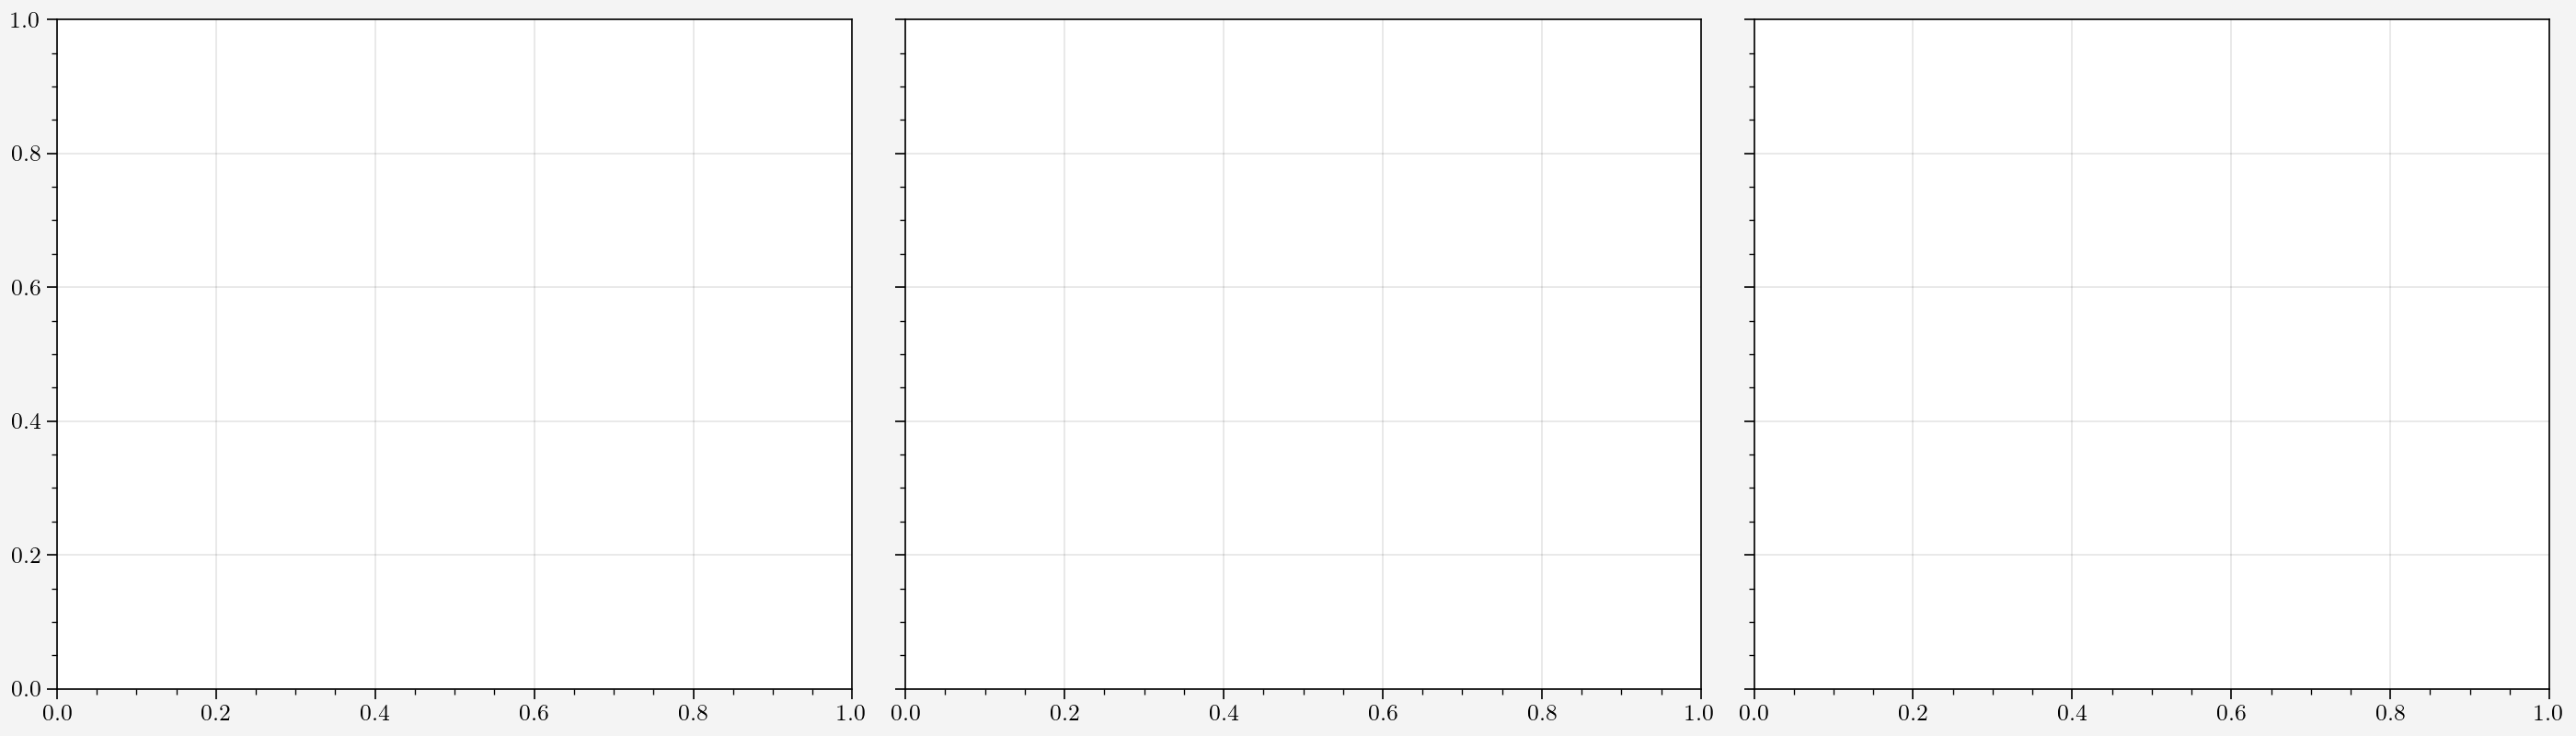

In [10]:
# V = W[1:,:] - W[:-1, ]
# V = V[2:-1,2:-2]
# U = W[:, 1:] - W[:, :-1]
# U = U[2:-2,2:-1]


fig, ax = pplt.subplots(nrows=1, ncols=3, figsize=(14, 4))
ax[0].contourf(Z2)
ax[0].set_title("Unobserved potential")

KU = potentials.diff_change_pot(19, 0)
KV = potentials.diff_change_pot(19, 1)
tmpU = signal.correlate2d(np.sign(U), KU, mode='same')
tmpV = signal.correlate2d(np.sign(V), KV, mode='same')
logits = tmpU + tmpV

d = 5
ax[1].quiver(
    X[::d, ::d],
    Y[::d, ::d],
    1.5 * d * V[::d, ::d],
    1.5 * d * U[::d, ::d],
)
ax[1].set_title("Simulated gradient field")
ax[2].contourf(logits)
ax[2].set_title("Treatment logits")

Text(0, 0.5, 'logits')

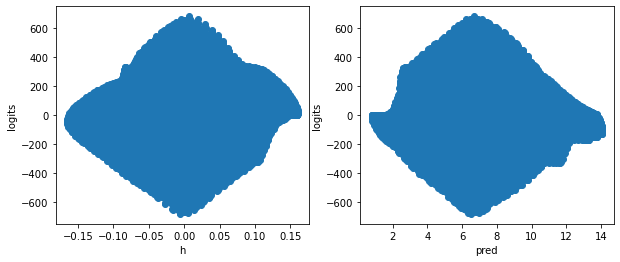

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].scatter(U.reshape(-1), logits.reshape(-1))
ax[0].set_xlabel("h")
ax[0].set_ylabel("logits")

X = np.stack([np.ones_like(U).reshape(-1), U.reshape(-1), V.reshape(-1)], 1)
y = logits.reshape(-1)
bhat = np.linalg.solve(X.transpose() @ X, X.transpose() @ y)
yhat = X @ bhat
ax[1].scatter(yhat, y)
ax[1].set_xlabel("pred")
ax[1].set_ylabel("logits")

Text(0, 0.5, 'logits')

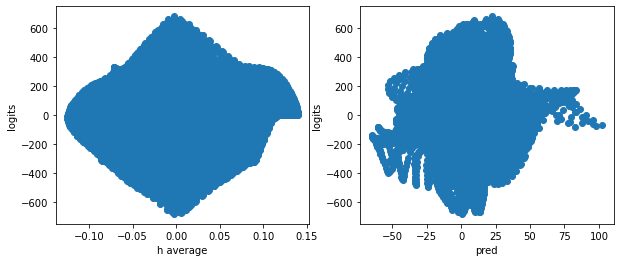

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ksize = 19
kavg = np.ones((ksize, ksize)) / ksize**2
Uavg = signal.correlate2d(U, kavg, mode='same')
Vavg = signal.correlate2d(V, kavg, mode='same')

ax[0].scatter(Uavg.reshape(-1), logits.reshape(-1))
ax[0].set_xlabel("h average")
ax[0].set_ylabel("logits")

X = np.stack([np.ones_like(U).reshape(-1), U.reshape(-1), V.reshape(-1), Uavg.reshape(-1), Vavg.reshape(-1)], 1)
y = logits.reshape(-1)
bhat = np.linalg.solve(X.transpose() @ X, X.transpose() @ y)
yhat = X @ bhat
ax[1].scatter(yhat, y)
ax[1].set_xlabel("pred")
ax[1].set_ylabel("logits")

Text(0, 0.5, 'logits')

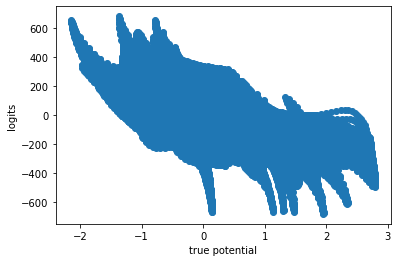

In [ ]:
potential = Z2[2:-2, 2:-2]
plt.scatter(potential.reshape(-1), logits.reshape(-1))
plt.xlabel("true potential")
plt.ylabel("logits")

`## Analysis with real vector fields

In [ ]:
DATAPATH = "E:/power_plant_data/grid_training_data_ozone_and_so4.pkl"
with open(DATAPATH, "rb") as io:
    data = pickle.load(io)

In [ ]:
Clayers = [8, 9]  # WIND COMPOS
C = data["covars_rast"][:, Clayers]
t = 6

In [ ]:
X, Y = np.meshgrid(np.arange(nc), np.arange(nr))
U = C[t,0]
V = C[t,1]

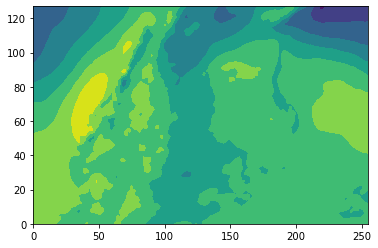

In [ ]:
plt.contourf(V)

In [ ]:
def integrate(X, axis):
    return X.cumsum(axis)

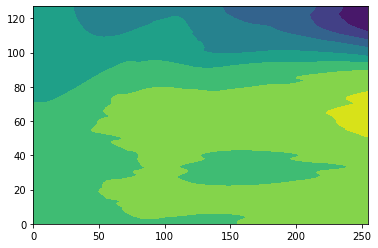

In [ ]:
Z0, Z1 = U, V
I0 = integrate(Z0, 0)
I1 = integrate(Z1, 1)
f1 = I1 - I0
P = I0 + f1
plt.contourf(P)

In [ ]:
np.abs(diff(P, 0) - U).mean()

7.98831

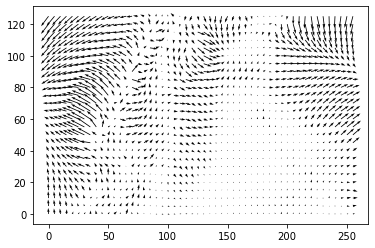

In [ ]:

d = 5
plt.quiver(
    X[::d, ::d],
    Y[::d, ::d],
    1.5 * d * U[::d, ::d],
    1.5 * d * V[::d, ::d]
)

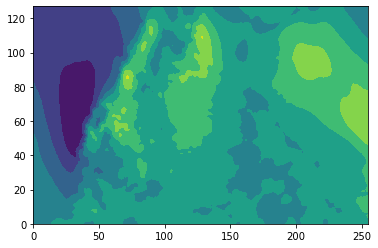

In [ ]:
plt.contourf(U)

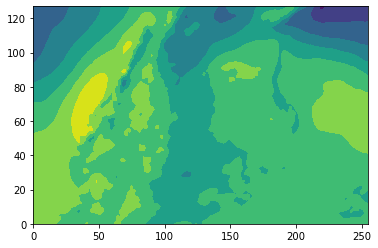

In [ ]:
plt.contourf(V)

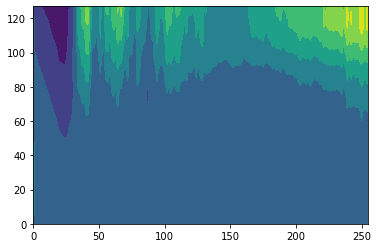

In [ ]:
X, Y = np.meshgrid(np.arange(nc), np.arange(nr))
P = U.cumsum(0) - V.cumsum(1) # integrate overy
dy = P[:, :-1] - P[:, 1:]  # it should match the V component
dy = np.concatenate([np.zeros((nr, 1)), dy], 1)
erry = U - dy
dx = P[:-1] - P[1:]  # it should match the V component
dx = np.concatenate([np.zeros((1, nc)), dy])
errx = V - dy
P = P + errx.cumsum(0) + erry.cumsum(1)

#  + V.cumsum(1)
# P -= P.mean()
# P /= P.std()
# print(P.max())
# print(P.min())
# # Z2 = np.clip(Z2, -1, 1)
plt.contourf(P)

4.091076539633367
-3.134125587180937


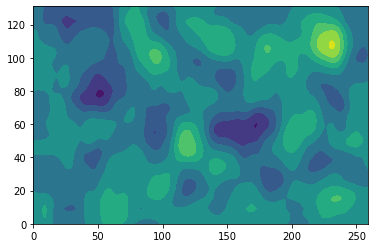

In [ ]:
LP = local_potential(ksize=19)
logits = signal.correlate2d(Z2, LP, mode='same')
logits -= logits.mean()
logits /= logits.std()
print(logits.max())
print(logits.min())
plt.contourf(logits)

ValueError: x and y must be the same size

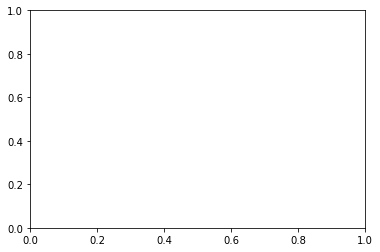

In [ ]:
plt.scatter(U.reshape(-1), logits.reshape(-1))
plt.xlabel("h component")
plt.ylabel("logits")

Text(0, 0.5, 'logits')

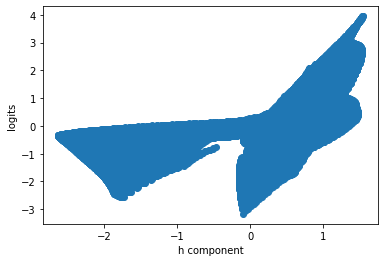

In [ ]:
ksize = 19
kavg = np.ones((ksize, ksize)) / ksize**2
Uavg = signal.correlate2d(U, kavg, mode='same')

plt.scatter(Uavg.reshape(-1), logits.reshape(-1))
plt.xlabel("h component")
plt.ylabel("logits")

Text(0, 0.5, 'logits')

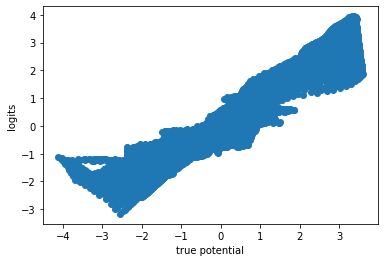

In [ ]:
plt.scatter(P.reshape(-1), logits.reshape(-1))
plt.xlabel("true potential")
plt.ylabel("logits")